In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
from matplotlib.animation import FuncAnimation
import seaborn as sns

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [2]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

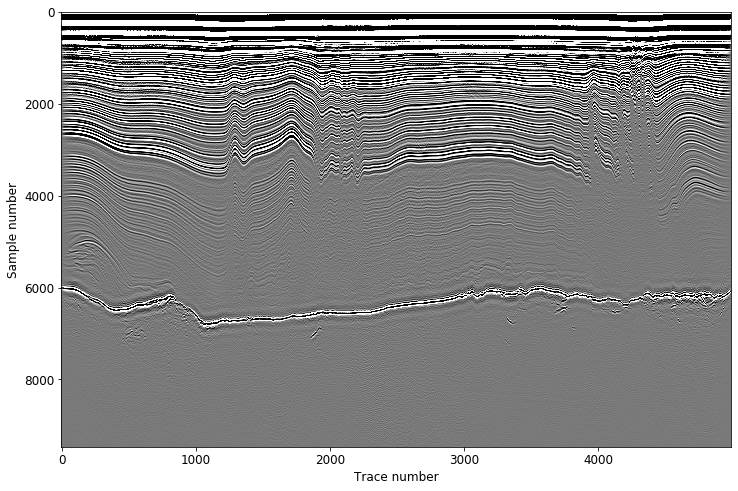

In [3]:
#original image
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [4]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [5]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [6]:
#positive contours
for contour in pos:
    c_pos.append(contour)
print('Done!\n')

#negative contours
for contour in neg:
    c_neg.append(contour)
print('Done!\n') 

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
print('Done!\n')
    
for contour in neg:
    c_length_neg.append(len(contour))
print('Done!\n')

Done!

Done!

Done!

Done!



In [7]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos = list(np.where(np.array(c_length_pos) > 500)[0])
long_contours_neg = list(np.where(np.array(c_length_neg) > 500)[0])

38
44400
298
30373


In [8]:
#isolate some contours
last_long_idx = long_contours_neg[-30:]
last_long_contours = [neg[idx] for idx in last_long_idx]

In [48]:
z = 10
argx1 = np.argmin(last_long_contours[z][:, 1])
argx2 = np.argmax(last_long_contours[z][:, 1])

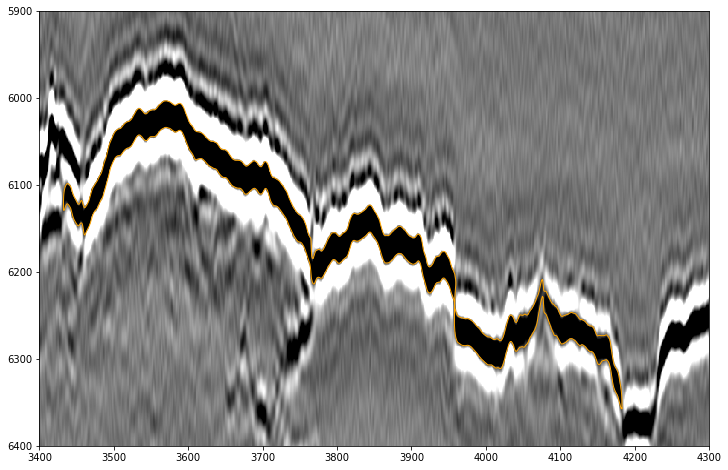

In [54]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

plt.xlim([3400, 4300])
plt.ylim([6400, 5900])

plt.show()

In [55]:
uniquex = (list(set([int(x) for x in last_long_contours[z][:, 1]])))

In [56]:
saved_points = []
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(last_long_contours[z][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points.append(wherex[1:3])
            #print(i, wherex[1:3])
        else:
            saved_points.append(wherex)
            #print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]

In [62]:
ridge_points = []
to_delete = []

In [63]:
for i, point in enumerate(saved_points):    
    if(len(point == 2)):
        idx1 = point[0]
        idx2 = point[1]
    elif(len(point > 2)):
        idx1 = point[1]
        idx2 = point[2]
    else:
        raise ValueException("You need to have at least two matching y-values.")
    
    x = uniquex[i]
    
    y1 = int(last_long_contours[z][idx1, 0])
    y2 = int(last_long_contours[z][idx2, 0])
    
    #check to see whether *both* points lie in a ridge or trough (for positive and negative contours)
    #only contains positive numbers: ridge --> search for troughs later
    if np.logical_and(data[y1, x] > 0, data[y2, x] > 0):
        if len(data[y2:y1, x]) == 0:
            ridge_points.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
        else:
            ridge_points.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])

    #only contains negative numbers: trough --> search for ridges later
    elif np.logical_and(data[y1, x] < 0, data[y2, x] < 0):
        if len(data[y2:y1, x]) == 0:
            ridge_points.append(np.where(data[:, x] == np.min(data[y1:y2, x]))[0])
        else:
            ridge_points.append(np.where(data[:, x] == np.min(data[y2:y1, x]))[0])

    #else the points contain both a positive and negative value, we need to skip over that
    #if we skip over that point, we need to delete it from uniquex and saved_points
    else:
        print(i, 'Here')
        to_delete.append(x)

14 Here
18 Here
79 Here
101 Here
103 Here
119 Here
124 Here
126 Here
128 Here
130 Here
131 Here
133 Here
136 Here
138 Here
144 Here
146 Here
147 Here
150 Here
151 Here
156 Here
157 Here
158 Here
159 Here
161 Here
162 Here
164 Here
168 Here
171 Here
172 Here
173 Here
176 Here
177 Here
180 Here
182 Here
184 Here
185 Here
186 Here
187 Here
188 Here
190 Here
191 Here
192 Here
193 Here
194 Here
195 Here
196 Here
203 Here
204 Here
206 Here
207 Here
208 Here
209 Here
210 Here
212 Here
213 Here
217 Here
218 Here
219 Here
221 Here
222 Here
223 Here
224 Here
225 Here
226 Here
227 Here
228 Here
230 Here
231 Here
232 Here
234 Here
235 Here
237 Here
238 Here
240 Here
241 Here
242 Here
243 Here
244 Here
245 Here
246 Here
247 Here
248 Here
249 Here
250 Here
251 Here
253 Here
254 Here
255 Here
257 Here
259 Here
260 Here
263 Here
266 Here
267 Here
271 Here
272 Here
274 Here
275 Here
278 Here
279 Here
282 Here
283 Here
285 Here
286 Here
287 Here
288 Here
290 Here
291 Here
293 Here
294 Here
295 Here
297 

In [64]:
print(to_delete, '\n')
print(uniquex)

[4110, 4114, 4175, 3446, 3448, 3464, 3469, 3471, 3473, 3475, 3476, 3478, 3481, 3483, 3489, 3491, 3492, 3495, 3496, 3501, 3502, 3503, 3504, 3506, 3507, 3509, 3513, 3516, 3517, 3518, 3521, 3522, 3525, 3527, 3529, 3530, 3531, 3532, 3533, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3548, 3549, 3551, 3552, 3553, 3554, 3555, 3557, 3558, 3562, 3563, 3564, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3575, 3576, 3577, 3579, 3580, 3582, 3583, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3598, 3599, 3600, 3602, 3604, 3605, 3608, 3611, 3612, 3616, 3617, 3619, 3620, 3623, 3624, 3627, 3628, 3630, 3631, 3632, 3633, 3635, 3636, 3638, 3639, 3640, 3642, 3643, 3644, 3647, 3648, 3649, 3650, 3652, 3653, 3655, 3656, 3659, 3661, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3671, 3673, 3680, 3682, 3683, 3685, 3686, 3687, 3688, 3689, 3690, 3695, 3696, 3699, 3701, 3703, 3704, 3705, 3706, 3708, 3709, 3710, 3713, 3715, 3716, 3718, 3719, 3721, 3724, 3725, 3726, 3727, 3730, 3735, 3738, 374

In [65]:
uniquex = [x for x in uniquex if x not in to_delete]

In [66]:
print(len(saved_points))
print(len(uniquex))
print(len(ridge_points))

751
480
480


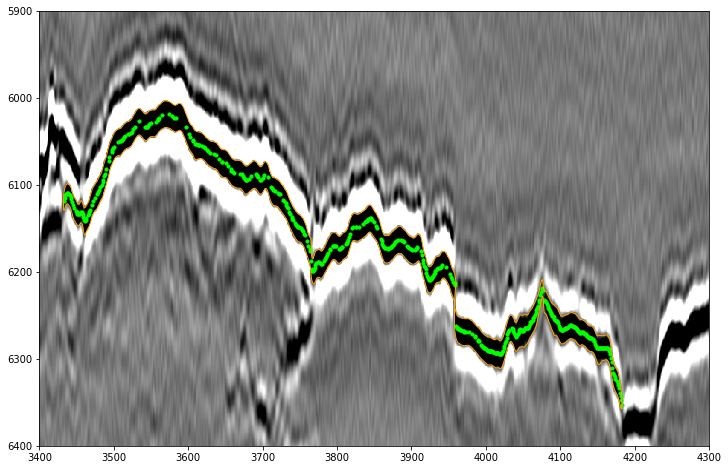

In [67]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

for i, x in enumerate(uniquex):
    y = ridge_points[i]
    ax.scatter(x, y, color='lime', marker='o', s=10)

plt.xlim([3400, 4300])
plt.ylim([6400, 5900])


plt.show()

### What about the troughs? We will need them to keep track of the entire wavelet (trough-peak-trough).

We could:
- take the derivative of the image and see where we see zeros
- we could use the original image and then see where the first place is (above and below) that we see a changing in sign (+ --> - for positive contours, - --> + for negative contours)

In [68]:
def find_ridges_troughs(uniquex, ridge_points, data):
    maxrows, maxcols = np.shape(data)
    
    top, bottom = [], []
    temptop_idx, tempbottom_idx = [], []
    temptop_points, tempbottom_points = [], []

    for i, point in enumerate(uniquex):
        row = ridge_points[i][0]
        col = point
        
        print(row, col)

        #if the point holds a negative value, then we want to
        #find the ridges on either side of it
        if data[row, col] < 0:
            #look for top contour
            for j in range(row, maxrows):
                #enter the ridge
                if (data[j, col] >= 0):
                    temptop_idx.append(j)
                    temptop_points.append(data[j, col])

                    #enterting this if statement would signify leaving the trough
                    if data[j+1, col] < 0:
                        #find the maximum in that column of the ridge
                        ridge_max = np.argmax(temptop_points)
                        top.append(temptop_idx[ridge_max])

                        #reset these to empty for the next column
                        temptop_idx, temptop_points = [], []
                        break

            #look for bottom contour
            for k in range(0, row):
                #enter the ridge
                if (data[row-k, col] >= 0):
                    tempbottom_idx.append(row-k)
                    tempbottom_points.append(data[row-k, col])

                    #enterting this if statement would signify leaving the ridge
                    if data[row-k-1, col] < 0:
                        #find the minimum in that column of the trough
                        ridge_bottom_max = np.argmax(tempbottom_points)
                        bottom.append(tempbottom_idx[ridge_bottom_max])

                        #reset these to empty for the next column
                        tempbottom_idx, tempbottom_points = [], []
                        break

    return top, bottom

In [69]:
top, bottom = find_ridges_troughs(uniquex, ridge_points, data)

6257 4096
6259 4097
6262 4098
6264 4099
6266 4100
6267 4101
6267 4102
6267 4103
6267 4104
6266 4105
6266 4106
6265 4107
6265 4108
6264 4109
6263 4111
6262 4112
6261 4113
6261 4115
6262 4116
6262 4117
6263 4118
6263 4119
6263 4120
6264 4121
6266 4122
6267 4123
6268 4124
6269 4125
6270 4126
6270 4127
6269 4128
6269 4129
6269 4130
6270 4131
6270 4132
6271 4133
6272 4134
6273 4135
6274 4136
6275 4137
6275 4138
6276 4139
6276 4140
6276 4141
6276 4142
6277 4143
6277 4144
6279 4145
6280 4146
6283 4147
6285 4148
6287 4149
6288 4150
6288 4151
6288 4152
6287 4153
6287 4154
6287 4155
6287 4156
6287 4157
6287 4158
6287 4159
6287 4160
6287 4161
6287 4162
6287 4163
6288 4164
6289 4165
6291 4166
6294 4167
6299 4168
6304 4169
6311 4170
6316 4171
6319 4172
6321 4173
6323 4174
6326 4176
6328 4177
6330 4178
6334 4179
6339 4180
6343 4181
6347 4182
6353 4183
6119 3433
6115 3434
6112 3435
6110 3436
6109 3437
6109 3438
6110 3439
6111 3440
6112 3441
6114 3442
6116 3443
6120 3444
6123 3445
6127 3447
6130 3449


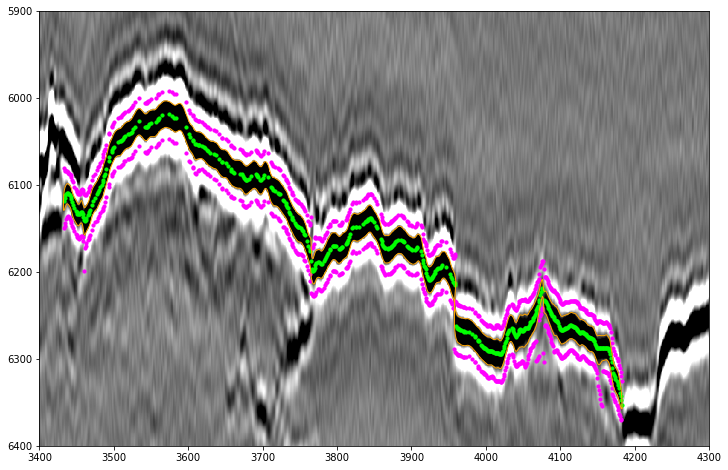

In [70]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

#plot contour
plt.plot(last_long_contours[z][:, 1], last_long_contours[z][:, 0], color='orange', linewidth=1)

#plot ridge and troughs
for i, x in enumerate(uniquex):
    y = ridge_points[i]
    t = top[i]
    b = bottom[i]
    ax.scatter(x, y, color='lime', marker='o', s=10)
    ax.scatter(x, t, color='magenta', marker='o', s=10)
    ax.scatter(x, b, color='magenta', marker='o', s=10)

plt.xlim([3400, 4300])
plt.ylim([6400, 5900])

plt.show()